<a href="https://colab.research.google.com/github/ericlrf/rul/blob/main/Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting when a machine will break

https://square.github.io/pysurvival/tutorials/maintenance.html

In [2]:
!pip install pysurvival

In [3]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

# Reading the dataset
raw_dataset = Dataset('maintenance').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (1000, 7).


,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1


In [4]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lifetime        1000 non-null   int64  
 1   broken          1000 non-null   int64  
 2   pressureInd     1000 non-null   float64
 3   moistureInd     1000 non-null   float64
 4   temperatureInd  1000 non-null   float64
 5   team            1000 non-null   object 
 6   provider        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [5]:
raw_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
lifetime,1000.0,55.195000,26.472737,1.000000,34.000000,60.000000,80.000000,93.000000
broken,1000.0,0.397000,0.489521,0.000000,0.000000,0.000000,1.000000,1.000000
pressureInd,1000.0,98.599338,19.964052,33.481917,85.558076,97.216997,112.253190,173.282541
moistureInd,1000.0,99.376723,9.988726,58.547301,92.771764,99.433959,106.120762,128.595038
temperatureInd,1000.0,100.628541,19.633060,42.279598,87.676913,100.592277,113.662885,172.544140


In [6]:
raw_dataset.describe(include=[object]).T

,count,unique,top,freq
team,1000,3,TeamB,356
provider,1000,4,Provider2,266


In [7]:
raw_dataset.broken.value_counts()

0    603
1    397
Name: broken, dtype: int64

In [8]:
raw_dataset.lifetime.value_counts()

65    82
80    71
88    46
60    39
81    33
      ..
84     2
15     2
89     1
90     1
87     1
Name: lifetime, Length: 90, dtype: int64

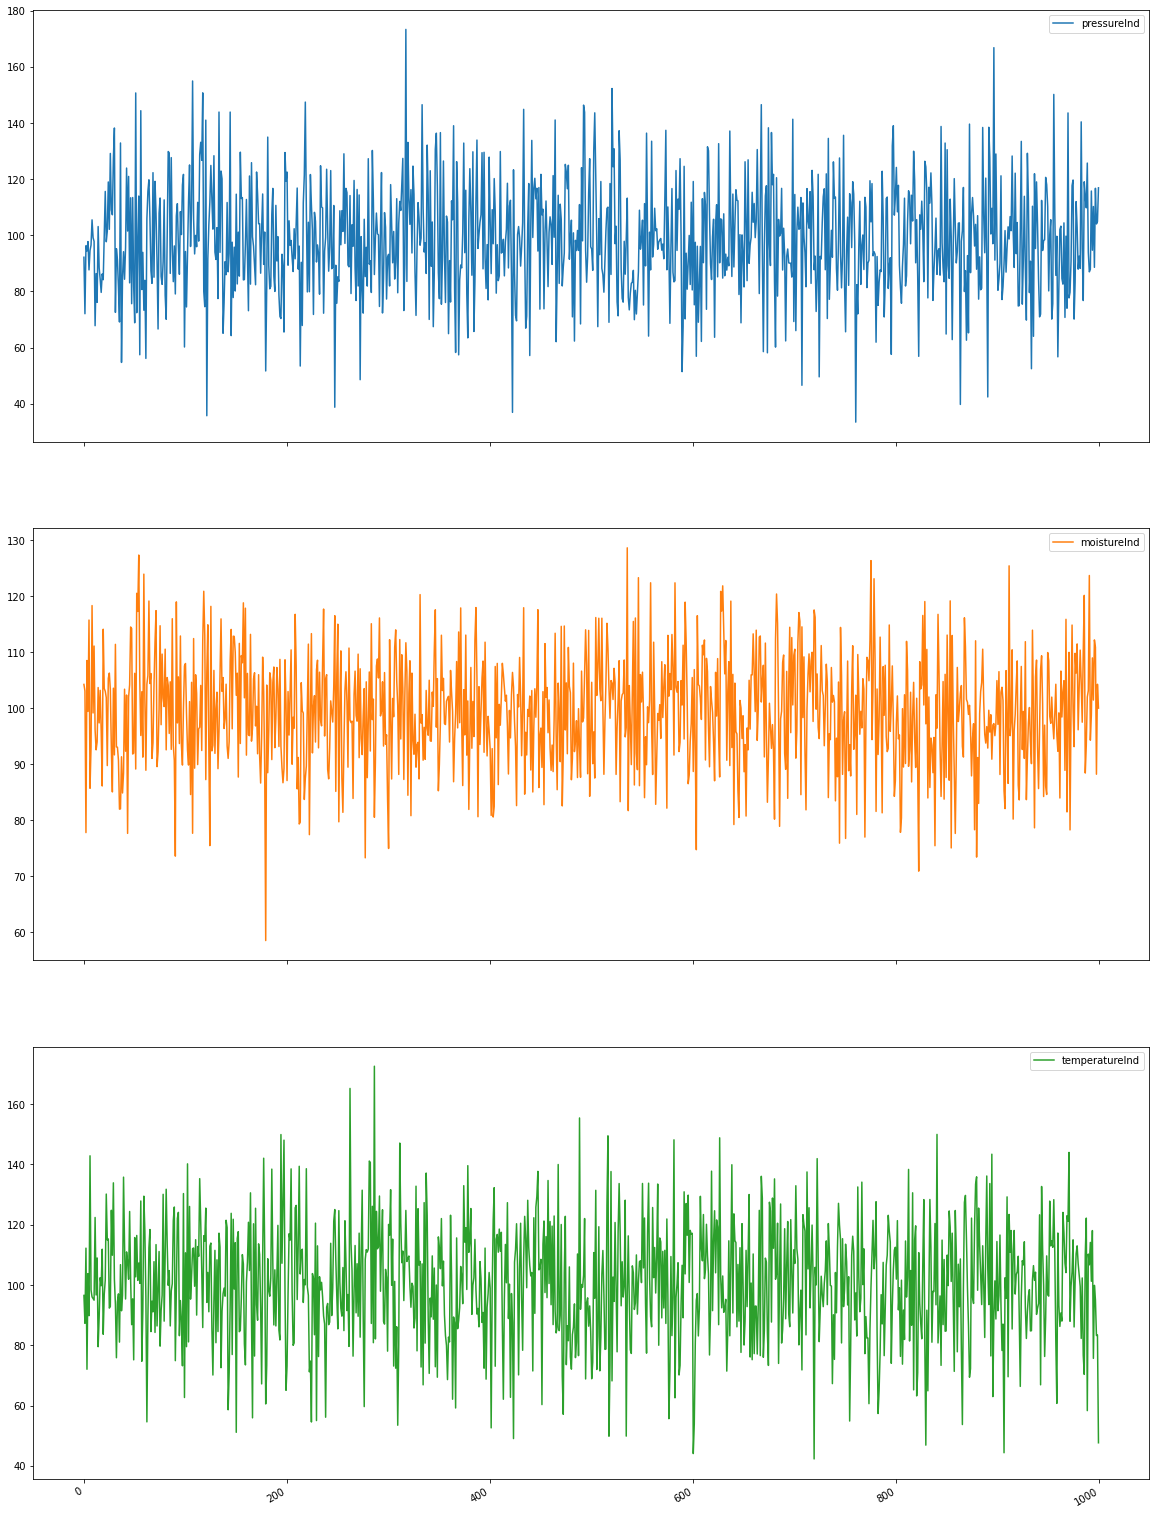

In [9]:
raw_dataset_copy = raw_dataset.copy()
raw_dataset_copy.set_index('lifetime')
raw_dataset_copy.sort_index()
ax1 = raw_dataset_copy.select_dtypes(include=['float64']).plot(subplots=True, sharex=True, figsize=(20,30))
# raw_dataset_copy.select_dtypes(include=['float64'])

In [10]:
# Defining the time and event column
time_column = 'lifetime'
event_column = 'broken'

# Encoding the categorical variables as one-hot vectors
categories = ['provider', 'team']
dataset = pd.get_dummies(raw_dataset, columns = categories, drop_first=True)

# Defining the modeling features
features = np.setdiff1d(dataset.columns, ['lifetime', 'broken']).tolist()

In [11]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The dataset contains 0 null values
The dataset contains 0 duplicates


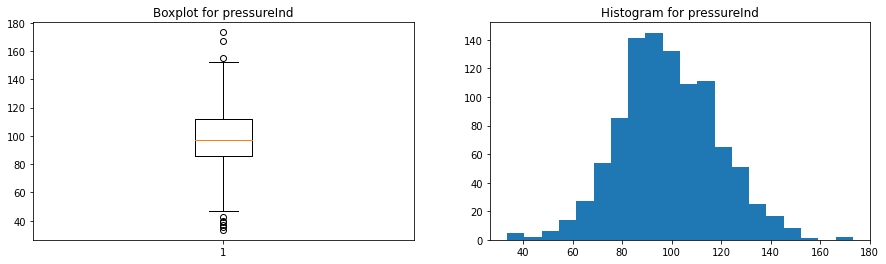

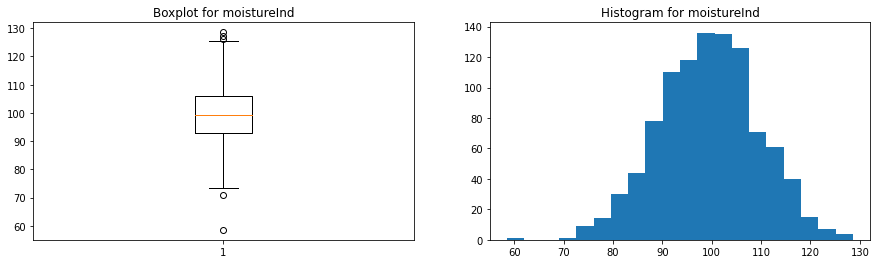

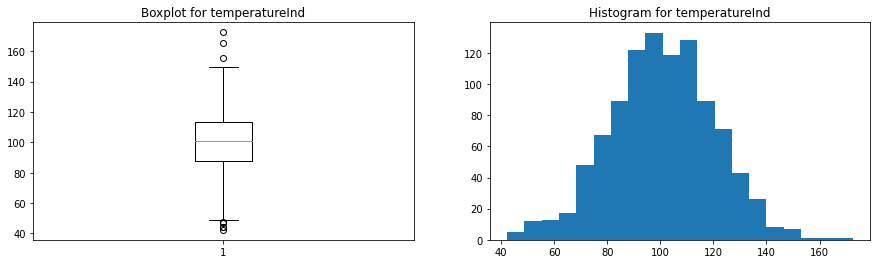

In [12]:
for feature in ['pressureInd','moistureInd','temperatureInd']:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Display
    plt.show()

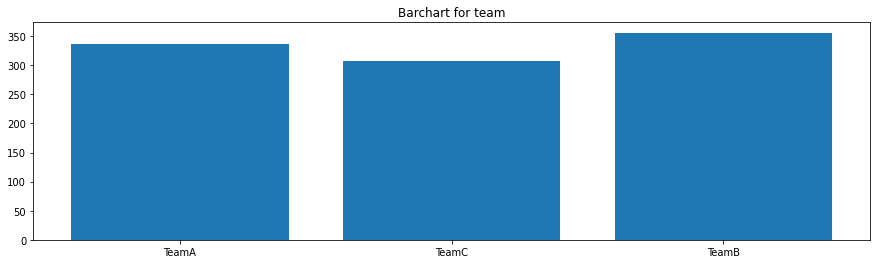

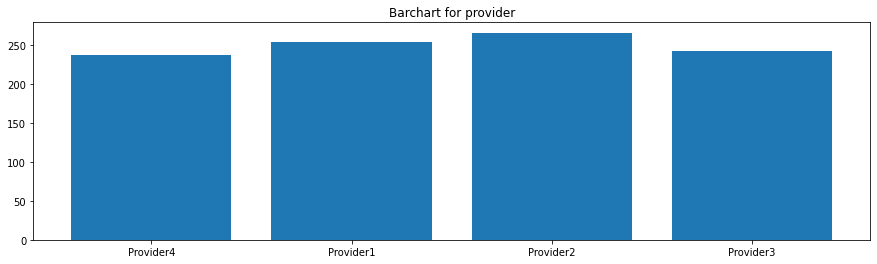

In [13]:
from collections import Counter
for feature in ['team','provider']:

    # Creating an empty chart
    fig, ax = plt.subplots(figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Counting the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    ax.bar(category, counts)

    # Display
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()

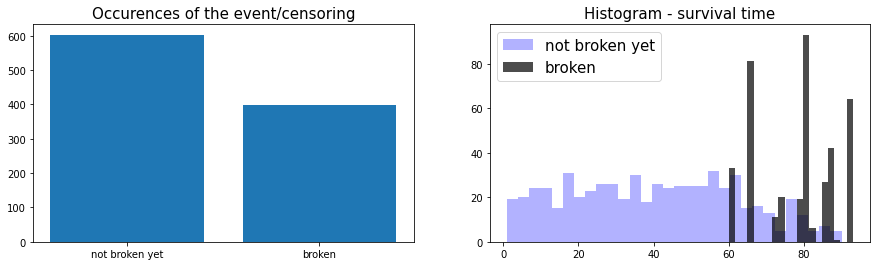

In [14]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['broken'].replace({0:'not broken yet', 1:'broken'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['broken'] == 0, 'lifetime']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not broken yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['broken'] == 1, 'lifetime']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'broken')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

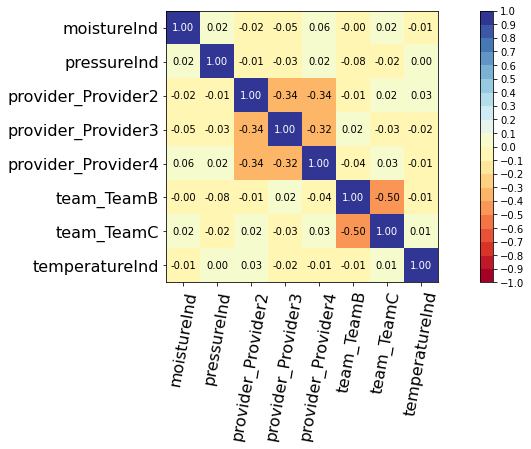

In [15]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(15, 5))

In [16]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.4)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [17]:
from pysurvival.models.multi_task import LinearMultiTaskModel

# Initializing the MTLR with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

# Fitting the model
linear_mtlr.fit(X_train, T_train, E_train, num_epochs = 1000,
                init_method = 'orthogonal', optimizer ='rmsprop',
                lr = 1e-3, l2_reg = 3,  l2_smooth = 3, )

LinearMultiTaskModel

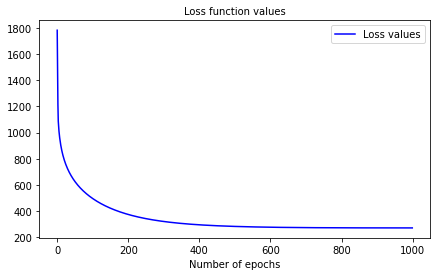

In [18]:
from pysurvival.utils.display import display_loss_values
display_loss_values(linear_mtlr, figure_size=(7, 4))

In [19]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(linear_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) #0.92

C-index: 0.93


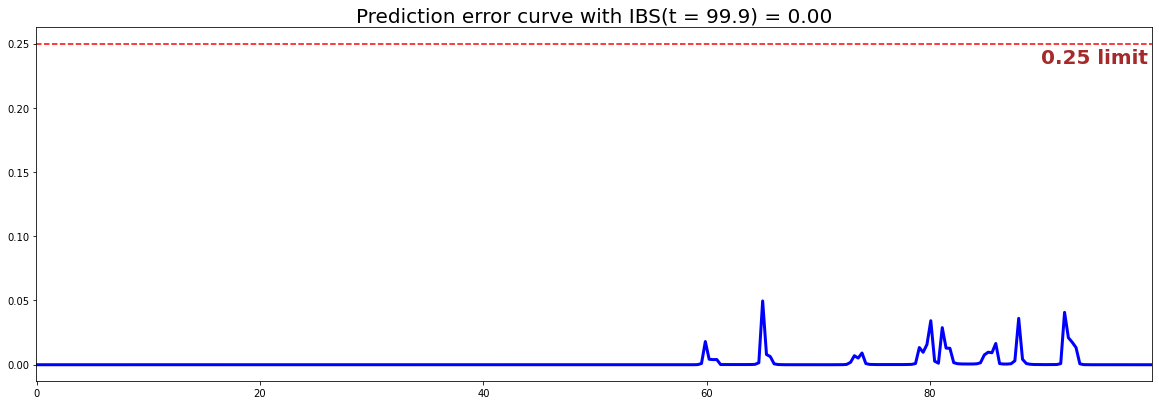

0.0015471747639675653

In [20]:
from pysurvival.utils.display import integrated_brier_score
integrated_brier_score(linear_mtlr, X_test, T_test, E_test, t_max=100,
                       figure_size=(20, 6.5) )

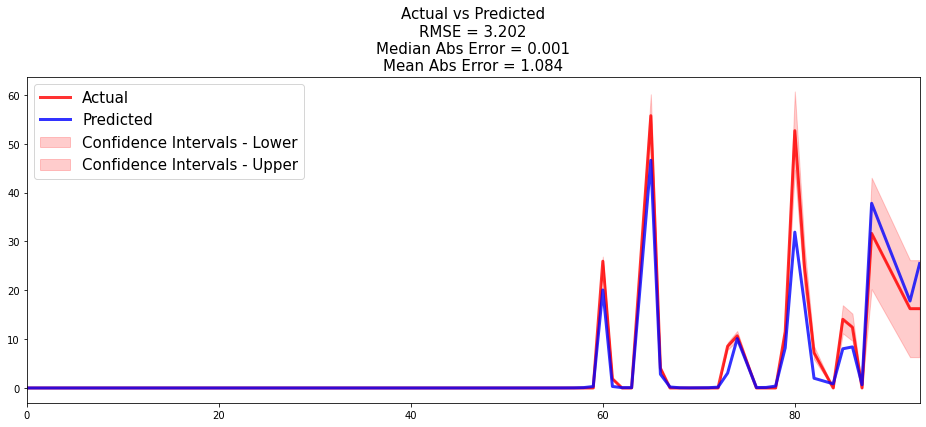

In [21]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(linear_mtlr, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

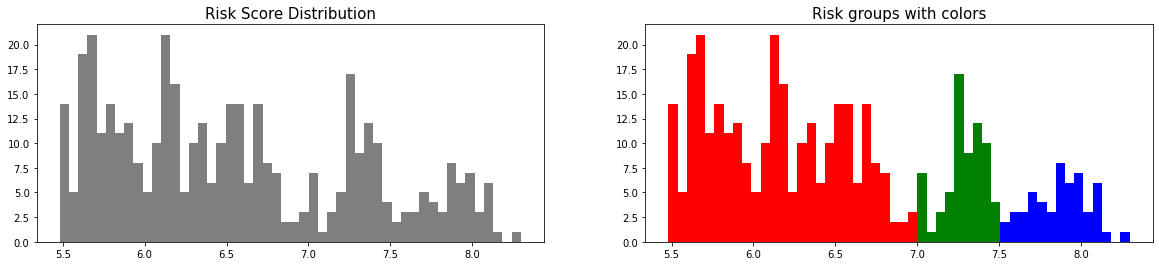

In [25]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=linear_mtlr, X=X_test,
    use_log = True, num_bins=50, figure_size=(20, 4),
    low= {'lower_bound':5.0, 'upper_bound':7.0, 'color':'red'},#manual operation after view
    medium= {'lower_bound': 7.0, 'upper_bound':7.5, 'color':'green'},#manual operation after view
    high= {'lower_bound':7.5, 'upper_bound':8.5, 'color':'blue'}#manual operation after view
    )

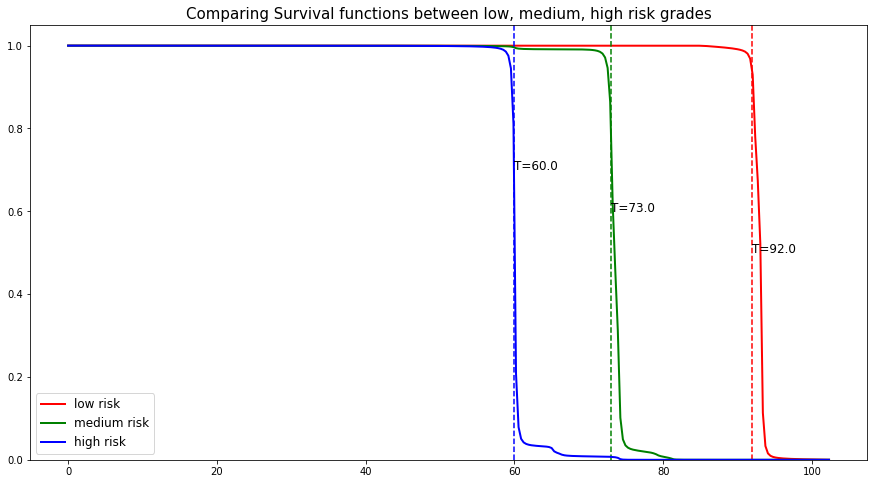

In [26]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 8))

# Selecting a random individual that experienced failure from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting a machine that experienced failure from each group
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = linear_mtlr.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(linear_mtlr.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

In [27]:
# Let's now save our model
from pysurvival.utils import save_model
save_model(linear_mtlr, 'pdm_linear_mtlr.zip')

Saving the model to disk as /pdm_linear_mtlr.zip


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  This is separate from the ipykernel package so we can avoid doing imports until
